# The Task

This task was to have 4 agents learn on a "grid world" of arbitrary size. The grid contained two locations: a "pickup" location and a "dropoff" location (dubbed A and B, respectively). More specifically, the agents were tasked to learn to pick up a package, and then drop off that package at the next location. The task seems _prim facie_ simple, but increases in complexity when mutli-agents are involved with accompanying use of Q updates where learning is reinforced.

In my assignment, I used Tabular Q and some reward heuristics for my agents to learn their job. What made a signifcantdifference in my project was the implementation of a penalty strategy when the agents were near each other. Making sure that collisions _at_ certain locations were not counted played a large role in my success rates. Sizable portions of my code (as I will show below) were dedicated to minimizing collisions.  

(I apologize, but I did not have enough time to fix my jupyter notebook and make it more seamless where one could simply Alt+Enter evy cell sequentially.)

# Hyperparameters
Below is the initialization of the grid world, the agent's actions, and the the goal states. I also added the variables that would be responsible for tracking the agents's coordinates and location coordinates: 

In [ ]:
import numpy as np
import random as RD
import time
import matplotlib.pyplot as plt

class Tabular_Q_Learning:
    def __init__(self, grid_size):
        # Grid setup
        self.grid_size = grid_size
        self.grid_world = tuple((x, y) for x in range(grid_size) for y in range(grid_size))
        
        # Required: exactly 4 actions (no wait action)
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # north, south, west, east
        
        # Agents setup
        self.num_agents = 4
        self.agent_positions = []
        self.goal_positions = []
        
        # Trackers
        self.total_steps = 0
        self.collision_count = 0
        self.success_counts = [0] * self.num_agents
        self.a = None  # Location A
        self.b = None  # Location B
        self.start_time = None

I then inlcuded the Q-Learning aspect of the program. Here, I wanted to make modest goals and deltas for the learning processes. I decided to use a slow decaying epsilon, which increased exploration at the early stateges, and a low learning rate to prioritize long-term rewards. One thing I wanted to avoid was for the agents to "over shoot" their targets.


In [ ]:
def proxy(self):
    self.q_tables = [np.zeros((grid_size, grid_size, grid_size, grid_size, 4)) 
                            for _ in range(self.num_agents)]        
    # -conservative Q-learning parameters for collision reduction
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.9999  # slow decay
    self.alpha = 0.08  # Slightly lower learning rate for stability
    self.gamma = 0.95

    # Budget constraints
    self.MAX_STEPS = 1_500_000
    self.MAX_COLLISIONS = 4_000
    self.MAX_TIME_SECONDS = 600  # 10 minutes
    self.start_time = None


Regrding the the conservative measures, they are easier to shown in the functions stop_training(). What makes this important is to prevent agents from getting stuck at a local minima, or reaching an absorbing state too early.

In [4]:
def stop_training(self, episode):
        """Stops the training early if achieving excellent performance with low collisions to avoid agents getting stuck"""
        if episode >= 10000:  
            success_rates = [count/episode for count in self.success_counts]
            avg_sr = sum(success_rates) / len(success_rates)
            
            
            if avg_sr >= 0.80 and self.collision_count <= 3000:
                print(f"\nstopping training")
                print(f"Success rate: {avg_sr:.3f},\n Collisions: {self.collision_count}")
                return True
        return False

### Q-Table Parameter

Below, the code implements the the initialization of the q-tables for each agent that of 5 dimensions that represent all the possible combinations of actions to be taken plus the action taken.

In [ ]:
# Q-tables: [agent_x, agent_y, goal_x, goal_y, action]
self.q_tables = [np.zeros((grid_size, grid_size, grid_size, grid_size, 4)) 
                for _ in range(self.num_agents)]

# Methods
### Q-Learning
Below demonstrates the implementation of Q updates for each step for each agent. This is the *off-policy* training as pect of the program.

with aim of achieving a policy that has 1) an optimal first action, and 2) an optimal policy from the successor state. 

This, in turn, aims to provide an iterative solution to the Bellman Optimality Equation:
$$
Q(s,a)←Q(s,a)+α(r+γ\sum_{s'}\underset{a'}{max}​Q(s',a')−Q(s,a))
$$
This can be seen under "core update rule"



In [ ]:
def step(self, agent_idx, action):
    """Execute action with enhanced collision-avoidance rewards"""
    x, y = self.agent_positions[agent_idx]
    gx, gy = self.goal_positions[agent_idx]
    
    # Calculate new position
    dx, dy = self.actions[action]
    new_x, new_y = x + dx, y + dy
    
    # Check bounds
    if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
        new_pos = (new_x, new_y)
        reward = 0
    else:
        new_pos = (x, y)  # Stay in place if out of bounds
        new_x, new_y = x, y
        reward = -2  # Higher wall penalty
    
    # Enhanced reward structure for collision avoidance
    if (new_x, new_y) == (gx, gy):
        reward += 20  # Very high goal reward
        
        # Efficiency bonus - reward faster completion
        dist_to_goal = abs(x - gx) + abs(y - gy)
        reward += max(0, 5 - dist_to_goal)  # Bonus for being close to goal
    else:
        # Distance-based reward shaping
        old_dist = abs(x - gx) + abs(y - gy)
        new_dist = abs(new_x - gx) + abs(new_y - gy)
        if new_dist < old_dist:
            reward += 0.3  # Good progress reward
        elif new_dist > old_dist:
            reward -= 0.2  # Small penalty for moving away
    
    # Strong proximity penalty for collision avoidance
    nearby_opposite = self.check_nearby_opposite_agents(agent_idx, new_pos)
    if nearby_opposite > 0:
        reward -= 1.0 * nearby_opposite  # Strong penalty for being near opposite agents
    
    # Q-learning update
    q_current = self.q_tables[agent_idx][x, y, gx, gy, action]
    '''core updte rule'''
    q_next_max = np.max(self.q_tables[agent_idx][new_x, new_y, gx, gy])
    q_updated = q_current + self.alpha * (reward + self.gamma * q_next_max - q_current)
    self.q_tables[agent_idx][x, y, gx, gy, action] = q_updated
    
    return new_pos, (new_pos == (gx, gy))

# Epislon Greedy & GLIE

To ensure that the agents are making the best decisions within the specified parameters, as well as account for cases in which the agent's local optimal policy may not be the best policy, we need to include a condition that demarcates *exploration* and *exploitation*. Below is the code that implements the exponentially decaying greedy (epsilon) choice or randoimized choice that the agents are allowed to take. We can formulate this distinction as a probability distribution due to its stochastic nature:

$$
\text{for policy }\  \pi \ \text{ and for a Q value } \ Q(s,a) \\
\pi (s,a)=\begin{cases}\epsilon/m+1-\epsilon, \ \ \ if \ a^*=\underset{a in A}argmaxQ(s,a) \\ \epsilon/m, \ \ \ \ otherwise\end{cases}
$$

Below we have the random() method within the condiitonal which, if the value is less than the decaying epsilon, then a random action is taken, otherwise argmax() is called and the agents maximize their rewards given the Q value at that step. 

This allows for the agents to infinitely explore greedily as the decay value appraoches 0, with convergence at 
$$
\lim_{k-> \infty} \pi _k(a|s)=1(a=\underset{a' \in A}{\mathrm{argmax}}Q(s',a'))
$$

In [ ]:
def get_action(self, agent_idx):
        """epsilon greedy policy"""
        x, y = self.agent_positions[agent_idx]
        gx, gy = self.goal_positions[agent_idx]
        
        if RD.random() < self.epsilon:
            return RD.randint(0, 3)  # Random action
        else:
            return np.argmax(self.q_tables[agent_idx][x, y, gx, gy])

The train() function and the step() essentially put everything together.

In [ ]:
def train(self, max_episodes=50000):
        """Main training loop with comprehensive monitoring"""
        print("Starting  Collision-Reduced Q-Learning Training...")
        print("Constraints: 5x5 grid, 4 agents, 4 actions, basic Q-learning only")
        print("Target: Well under 4000 collisions while maintaining 75%+ success rate")
        print("-" * 70)
        
        self.start_time = time.time()
        
        for episode in range(max_episodes):
            self.run_episode()
            
            # Progress report
            if (episode + 1) % 3000 == 0:
                elapsed = time.time() - self.start_time
                success_rates = [count/(episode+1) for count in self.success_counts]
                avg_sr = sum(success_rates) / len(success_rates)
                print(f"Episode {episode+1}: SR={avg_sr:.3f}, Collisions={self.collision_count}, "
                      f"Steps={self.total_steps}, Time={elapsed:.1f}s, Eps={self.epsilon:.4f}")
            
            # Check for early stopping with good performance
            if self.should_stop_early(episode + 1):
                self.print_results(episode + 1)
                return
            
            # Check budget constraints
            if self.check_budgets(episode + 1):
                self.print_results(episode + 1)
                return
        
        self.print_results(max_episodes)

## Optimization 
### Reward Heuristics

We are now ready to implement one of the most crucial parts of the program that has cascading impacts on the learning process and the Q-tables. Here I structure the positive and negative rewards that the agents receive based on seval factors:
1. the agents are rewarded if they end up close to the close at t0 by use of manhattan distance measurement.
2. each agent receives a proximity penalty for being near other agents
3. a high reward is granted to agents who have reached the goal, and have avoided collisions doing so this allows the reward mechanism to back-propagate to the q value updating process.

In [ ]:
# Enhanced reward structure for collision avoidance
if (new_x, new_y) == (gx, gy):
    reward += 20  # Very high goal reward
    
    # Efficiency bonus - reward faster completion
    dist_to_goal = abs(x - gx) + abs(y - gy)
    reward += max(0, 5 - dist_to_goal)  # Bonus for being close to goal

# Strong proximity penalty for collision avoidance
nearby_opposite = self.check_nearby_opposite_agents(agent_idx, new_pos)
if nearby_opposite > 0:
    reward -= 1.0 * nearby_opposite  # Strong penalty for being near opposite agents
    

### Collision Handling

In the following functions, I attempt to optimize _how_ the agents recognize collisions and how they maneuver around the ones they found.

In the function dectect_collisions(), I simply iterate the times collisions occur, which includes the function head_on_collision() that tracks specifically when an agent going towards its goal comes into contact with another agent going towards its own goal that is opposite.

In [ ]:
def head_on_collision(self, agent1_idx, agent2_idx, prev_pos1, new_pos1, prev_pos2, new_pos2):
    """Check for head-on collision (A→B vs B→A)"""
    goal1 = self.goal_positions[agent1_idx]
    goal2 = self.goal_positions[agent2_idx]
    
    # Must have opposite goals
    if goal1 == goal2:
        return False
    
    # Check A→B vs B→A collision
    if ((prev_pos1 == self.a and new_pos1 == self.b and goal1 == self.b) and
        (prev_pos2 == self.b and new_pos2 == self.a and goal2 == self.a)):
        return True
    if ((prev_pos1 == self.b and new_pos1 == self.a and goal1 == self.a) and
        (prev_pos2 == self.a and new_pos2 == self.b and goal2 == self.b)):
        return True
    
    return False

def detect_collisions(self, prev_positions, new_positions):
    """Detect head-on collisions"""
    collisions = []
    for i in range(self.num_agents):
        for j in range(i + 1, self.num_agents):
            if self.head_on_collision(i, j, prev_positions[i], new_positions[i],
                                       prev_positions[j], new_positions[j]):
                collisions.append((i, j))
    return collisions

### Budget Constraints

In the check_budgets() method, I compare the colected data to the budget constraints as outlined in the assignment description, including maximum steps, maximum collisions, and maximum wall time. 

In [ ]:
def check_budgets(self, episode):
    """Check if any budget exceeded"""
    # Check time budget
    if time.time() - self.start_time > self.MAX_TIME_SECONDS:
        print(f"\nTime budget exceeded at episode {episode}")
        return True
    
    # Check step budget  
    if self.total_steps >= self.MAX_STEPS:
        print(f"\nStep budget exceeded at episode {episode}")
        return True
        
    # Check collision budget with early warning
    if self.collision_count >= (self.MAX_COLLISIONS - 100):  # Stop 100 before limit
        print(f"\nApproaching collision budget - stopping early at episode {episode}")
        return True
        
    return False


# You can run the cell block below and it will output my results and visualizations of the assignment:

### Visualization

I aimed to have the epsilon decay *exponentially*, as expected from Q-learning. However, I was having trouble shwoing that in the graph, as it does not curve very well. So, to ensure that it was, I took the log of the decaying epsilon at cerain intervals:

The first is a non-log of epsilon decay, with the second being the log. Over 20,000 episodes, the log-transformed graph performs as expected. While it may not be the *best* representation of epsilon decay, I wanted to at least provide this given the little time left that I had.

The third graph is a bar graph of the success counts for each agent. What I typically notice is that the first agent is the one who most often gets the "short end of the stick" when it comes to explorationa nd exploitation. My interpretation is that due to the round-robin sequencing of actions, hoever goes first, loses. 

The last graph demonstrates the increase of rewards that the agents receive each episode. This strongly suggests that the agents are not only greedily exploring, but they are continuing down their greedy paths more frequently during sampling. I think of it like the foraging ants. When the ant releases hormonal chemicals such as dopamine that lead to th food source--as more ants appear, more ants greedily release more of the relevant hormones. This compounding processes eventually forms, _ceterus paribus_, an optimal trail from starting position to the food source. 

Starting Tabular Q-Learning Training...
----------------------------------------------------------------------
Episode 3000: SR=0.595, Collisions=137, Steps=69139, Time=1.2s, Eps=0.7408
Episode 6000: SR=0.755, Collisions=469, Steps=119675, Time=2.0s, Eps=0.5488
Episode 9000: SR=0.833, Collisions=979, Steps=154364, Time=2.6s, Eps=0.4066
Episode 12000: SR=0.875, Collisions=1628, Steps=180265, Time=3.1s, Eps=0.3012
Episode 15000: SR=0.900, Collisions=2364, Steps=201153, Time=3.6s, Eps=0.2231
Episode 18000: SR=0.916, Collisions=3157, Steps=219048, Time=3.9s, Eps=0.1653

stopping training
Success rate: 0.925,
 Collisions: 3767

FINAL RESULTS
Episodes completed: 20000
Training time: 4.2 seconds
Total steps: 229836
Head-on collisions: 3767
Collision budget remaining: 233

Agent 0 success rate: 18475/20000 = 0.924
Agent 1 success rate: 18532/20000 = 0.927
Agent 2 success rate: 18451/20000 = 0.923
Agent 3 success rate: 18525/20000 = 0.926

Overall success rate: 0.925
Target success rate: 0.75
S

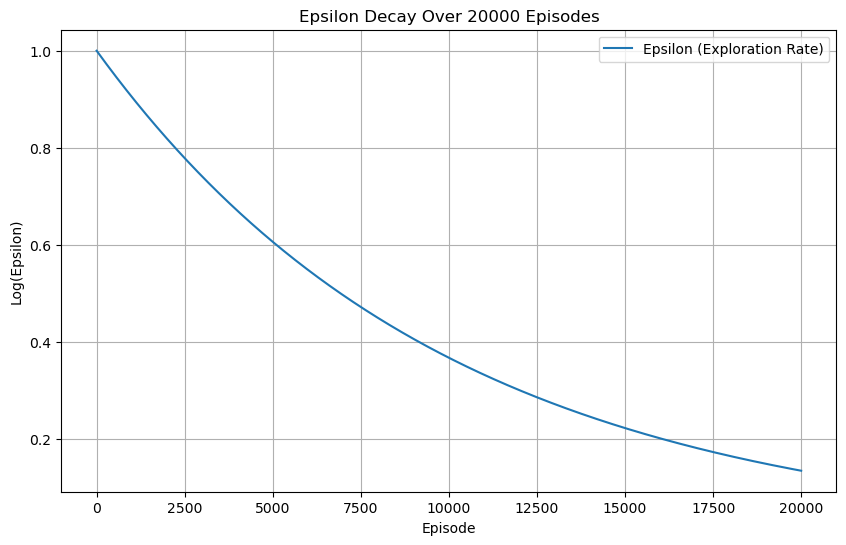

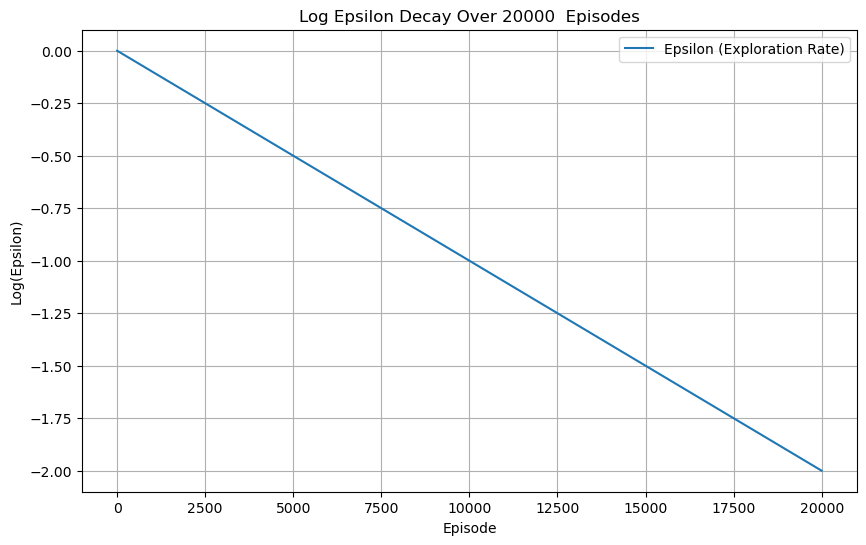

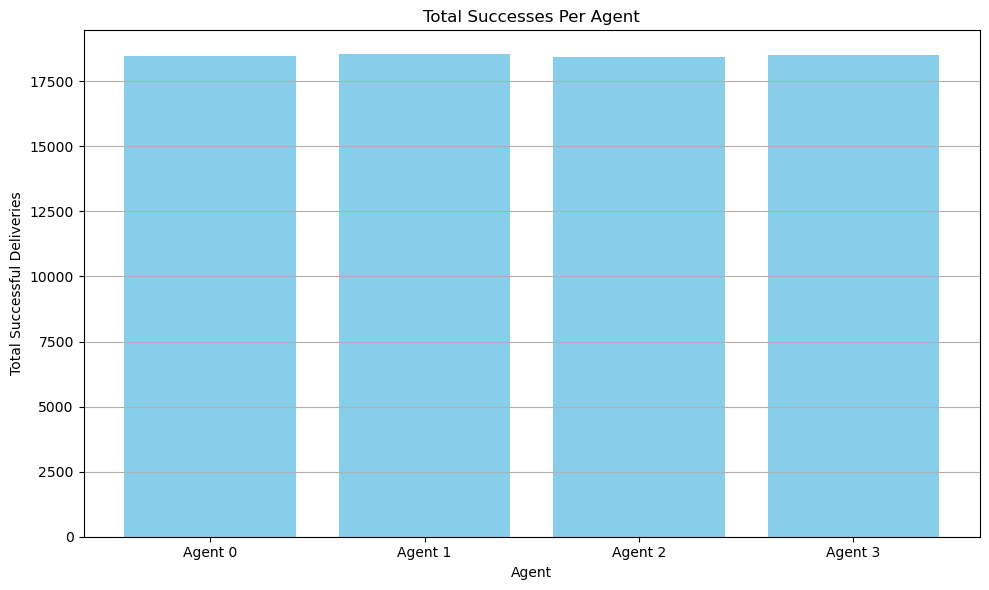

/tmp/ipykernel_52233/967801717.py:341: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(self.reward_data))


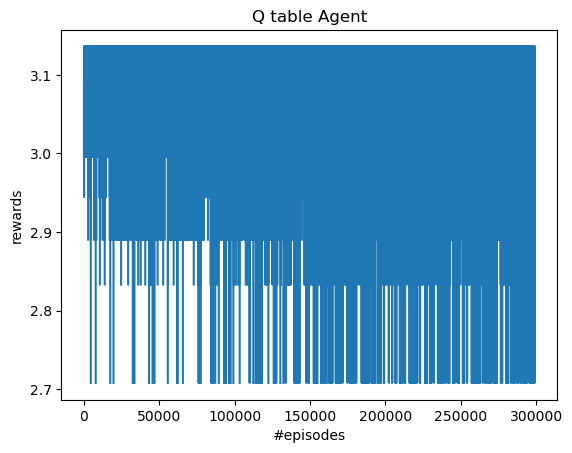


TRAINING COMPLETED


In [14]:
import matplotlib.pyplot as plt
import random as RD
import time as time
import numpy as np


class Tabular_Q_Learning:
    
    def __init__(self, grid_size):
        # Grid setup
        self.grid_size = grid_size
        self.grid_world = tuple((x, y) for x in range(grid_size) for y in range(grid_size))
        
        # Required: exactly 4 actions (no wait action)
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # north, south, west, east
        
        # Agents setup
        self.num_agents = 4
        self.agent_positions = []
        self.goal_positions = []
        
        # Tracking variables
        self.total_steps = 0
        self.collision_count = 0
        self.success_counts = [0] * self.num_agents
        self.a = None  # Location A
        self.b = None  # Location B
        self.reward_data = []
        
        # Q-tables: [agent_x, agent_y, goal_x, goal_y, action]
        self.q_tables = [np.zeros((grid_size, grid_size, grid_size, grid_size, 4)) 
                        for _ in range(self.num_agents)]
        
        # -conservative Q-learning parameters for collision reduction
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999  # Very conservative decay
        self.alpha = 0.08  # Slightly lower learning rate for stability
        self.gamma = 0.95
        self.epsilon_data = []
        
        # Budget constraints
        self.MAX_STEPS = 1_500_000
        self.MAX_COLLISIONS = 4_000
        self.MAX_TIME_SECONDS = 600  # 10 minutes
        self.start_time = None

    def setup_episode(self):
        # Random A and B locations where A != B
        coords = list(self.grid_world)
        self.a = RD.choice(coords)
        self.b = RD.choice(coords)
        while self.a == self.b:
            self.b = RD.choice(coords)
        
        # Agents start at A or B, with opposite as goal
        self.agent_positions = []
        self.goal_positions = []
        for _ in range(self.num_agents):
            start = RD.choice([self.a, self.b])
            goal = self.b if start == self.a else self.a
            self.agent_positions.append(start)
            self.goal_positions.append(goal)

    def get_action(self, agent_idx):
        """Basic epsilon-greedy action selection"""
        x, y = self.agent_positions[agent_idx]
        gx, gy = self.goal_positions[agent_idx]
        
        if RD.random() < self.epsilon:
            return RD.randint(0, 3)  # Random action
        else:
            return np.argmax(self.q_tables[agent_idx][x, y, gx, gy])

    def check_nearby_opposite_agents(self, agent_idx, test_pos):
        """Check for nearby opposite-direction agents (collision avoidance)"""
        my_goal = self.goal_positions[agent_idx]
        nearby_count = 0
        
        for other_idx, other_pos in enumerate(self.agent_positions):
            if (other_idx != agent_idx and 
                self.goal_positions[other_idx] != my_goal):  # Opposite direction
                dist = abs(other_pos[0] - test_pos[0]) + abs(other_pos[1] - test_pos[1])
                if dist == 0:  # Same position
                    nearby_count += 3  # Heavy penalty for same position
                elif dist == 1:  # Adjacent
                    nearby_count += 1  # Light penalty for adjacent
        
        return nearby_count

    def step(self, agent_idx, action):
        """Execute action with enhanced collision-avoidance rewards"""
        x, y = self.agent_positions[agent_idx]
        gx, gy = self.goal_positions[agent_idx]
        
        # Calculate new position
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy
        
        # Check bounds
        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            new_pos = (new_x, new_y)
            reward = 0
        else:
            new_pos = (x, y)  # Stay in place if out of bounds
            new_x, new_y = x, y
            reward = -2  # Higher wall penalty
            self.reward_data.append(reward)
        
        # Enhanced reward structure for collision avoidance
        if (new_x, new_y) == (gx, gy):
            reward += 20  # Very high goal reward
            self.reward_data.append(reward)
            # Efficiency bonus - reward faster completion
            dist_to_goal = abs(x - gx) + abs(y - gy)
            reward += max(0, 5 - dist_to_goal)  # Bonus for being close to goal
        # Strong proximity penalty for collision avoidance
        nearby_opposite = self.check_nearby_opposite_agents(agent_idx, new_pos)
        if nearby_opposite > 0:
            reward -= 1.0 * nearby_opposite  # Strong penalty for being near opposite agents
            self.reward_data.append(reward)
        # Q-learning update
        q_current = self.q_tables[agent_idx][x, y, gx, gy, action]
        q_next_max = np.max(self.q_tables[agent_idx][new_x, new_y, gx, gy])
        q_updated = q_current + self.alpha * (reward + self.gamma * q_next_max - q_current)
        self.q_tables[agent_idx][x, y, gx, gy, action] = q_updated
        
        return new_pos, (new_pos == (gx, gy))

    def head_on_collision(self, agent1_idx, agent2_idx, prev_pos1, new_pos1, prev_pos2, new_pos2):
        """Check for head-on collision (A→B vs B→A)"""
        goal1 = self.goal_positions[agent1_idx]
        goal2 = self.goal_positions[agent2_idx]
        
        # Must have opposite goals
        if goal1 == goal2:
            return False
        
        # Check A→B vs B→A collision
        if ((prev_pos1 == self.a and new_pos1 == self.b and goal1 == self.b) and
            (prev_pos2 == self.b and new_pos2 == self.a and goal2 == self.a)):
            return True
        if ((prev_pos1 == self.b and new_pos1 == self.a and goal1 == self.a) and
            (prev_pos2 == self.a and new_pos2 == self.b and goal2 == self.b)):
            return True
        
        return False

    def detect_collisions(self, prev_positions, new_positions):
        """Detect head-on collisions"""
        collisions = []
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                if self.head_on_collision(i, j, prev_positions[i], new_positions[i],
                                           prev_positions[j], new_positions[j]):
                    collisions.append((i, j))
        return collisions

    def run_episode(self):
        """Run single episode with collision penalty"""
        self.setup_episode()
        goals_reached = [False] * self.num_agents
        steps = 0
        prev_positions = self.agent_positions.copy()
        
        while steps < 25 and not all(goals_reached):
            # Sequential execution in random order
            agent_order = list(range(self.num_agents))
            RD.shuffle(agent_order)
            
            for agent_idx in agent_order:
                if not goals_reached[agent_idx]:
                    action = self.get_action(agent_idx)
                    new_pos, reached = self.step(agent_idx, action)
                    self.agent_positions[agent_idx] = new_pos
                    
                    if reached:
                        goals_reached[agent_idx] = True
                        self.success_counts[agent_idx] += 1
            
            # Check for collisions and apply very strong penalty
            collisions = self.detect_collisions(prev_positions, self.agent_positions)
            if collisions:
                self.collision_count += len(collisions)
                
                # Very strong collision penalty to Q-tables
                for agent_i, agent_j in collisions:
                    # Heavily penalize the state-action that led to collision
                    x, y = prev_positions[agent_i]
                    gx, gy = self.goal_positions[agent_i]
                    # Apply strong penalty to all actions from collision-prone state
                    for a in range(4):
                        self.q_tables[agent_i][x, y, gx, gy, a] -= 1.0
                    
                    # Same for second agent
                    x, y = prev_positions[agent_j] 
                    gx, gy = self.goal_positions[agent_j]
                    for a in range(4):
                        self.q_tables[agent_j][x, y, gx, gy, a] -= 1.0
            
            prev_positions = self.agent_positions.copy()
            steps += 1
            self.total_steps += 1
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        
        # Import for graphing
        self.epsilon_data.append(self.epsilon)

    def check_budgets(self, episode):
        """Check if any budget exceeded"""
        # Check time budget
        if time.time() - self.start_time > self.MAX_TIME_SECONDS:
            print(f"\nTime budget exceeded at episode {episode}")
            return True
        
        # Check step budget  
        if self.total_steps >= self.MAX_STEPS:
            print(f"\nStep budget exceeded at episode {episode}")
            return True
            
        # Check collision budget with early warning
        if self.collision_count >= (self.MAX_COLLISIONS - 100):  
            print(f"\nApproaching collision budget at episode {episode}")
            
            
        return False

    def stop_training(self, episode):
        """Stops the training early if achieving excellent performance with low collisions to avoid agents getting stuck"""
        if episode >= 20000:  
            success_rates = [count/episode for count in self.success_counts]
            avg_sr = sum(success_rates) / len(success_rates)
            
            
            if avg_sr >= 0.85 and self.collision_count <= 4000:
                print(f"\nstopping training")
                print(f"Success rate: {avg_sr:.3f},\n Collisions: {self.collision_count}")
                return True
        return False

    def train(self, max_episodes=50000):
        """Main training loop"""
        print("Starting Tabular Q-Learning Training...")
        print("-" * 70)
        
        self.start_time = time.time()
        
        for episode in range(max_episodes):
            self.run_episode()
            
            # Progress report
            if (episode + 1) % 3000 == 0:
                elapsed = time.time() - self.start_time
                success_rates = [count/(episode+1) for count in self.success_counts]
                avg_sr = sum(success_rates) / len(success_rates)
                print(f"Episode {episode+1}: SR={avg_sr:.3f}, Collisions={self.collision_count}, "
                      f"Steps={self.total_steps}, Time={elapsed:.1f}s, Eps={self.epsilon:.4f}")
            
            # Check for early stopping with good performance
            if self.stop_training(episode + 1):
                self.print_results(episode + 1)
                return
            
            # Check budget constraints
            if self.check_budgets(episode + 1):
                self.print_results(episode + 1)
                return
        
        self.print_results(max_episodes)

    def print_results(self, episodes):
        """Comprehensive results reporting"""
        print("\n" + "=" * 70)
        print("FINAL RESULTS")
        print("=" * 70)
        
        elapsed = time.time() - self.start_time
        success_rates = [count/episodes for count in self.success_counts]
        avg_success_rate = sum(success_rates) / len(success_rates)
        collision_margin = self.MAX_COLLISIONS - self.collision_count
        
        print(f"Episodes completed: {episodes}")
        print(f"Training time: {elapsed:.1f} seconds")
        print(f"Total steps: {self.total_steps}")
        print(f"Head-on collisions: {self.collision_count}")
        print(f"Collision budget remaining: {collision_margin}")
        print()
        
        for i, sr in enumerate(success_rates):
            print(f"Agent {i} success rate: {self.success_counts[i]}/{episodes} = {sr:.3f}")
        
        print(f"\nOverall success rate: {avg_success_rate:.3f}")
        print(f"Target success rate: 0.75")
        print(f"Success rate met: {'YES' if avg_success_rate >= 0.75 else 'NO'}")
        print(f"Collision budget met: {'YES' if self.collision_count < self.MAX_COLLISIONS else 'NO'}")
        print(f"Step budget met: {'YES' if self.total_steps <= self.MAX_STEPS else 'NO'}")
        print(f"Time budget met: {'YES' if elapsed <= self.MAX_TIME_SECONDS else 'NO'}")
        
        if (avg_success_rate >= 0.75 and self.collision_count < self.MAX_COLLISIONS and 
            self.total_steps <= self.MAX_STEPS and elapsed <= self.MAX_TIME_SECONDS):
            print("\n*** SUCCESS: All requirements and constraints satisfied! ***")
            if collision_margin >= 1000:
                print(f"*** EXCELLENT: {collision_margin} collisions under budget! ***")
            elif collision_margin >= 500:
                print(f"*** GOOD: {collision_margin} collisions under budget! ***")
        
        # Plot epsilon decay
        plt.figure(figsize=(10, 6))
        plt.plot(self.epsilon_data, label='Epsilon (Exploration Rate)')
        plt.xlabel('Episode')
        plt.ylabel('Log(Epsilon)')
        plt.title(f'Epsilon Decay Over {episodes} Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot log epsilon decay
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(self.epsilon_data), label='Epsilon (Exploration Rate)')
        plt.xlabel('Episode')
        plt.ylabel('Log(Epsilon)')
        plt.title(f'Log Epsilon Decay Over {episodes}  Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot Agent's success counts individually
        plt.figure(figsize=(10, 6))
        agent_labels = [f"Agent {i}" for i in range(len(self.success_counts))]
        plt.bar(agent_labels, self.success_counts, color='skyblue')
        plt.title("Total Successes Per Agent")
        plt.xlabel("Agent")
        plt.ylabel("Total Successful Deliveries")
        plt.tight_layout()
        plt.grid(axis='y')
        plt.show()


        plt.plot(np.log(self.reward_data))
        # Add x and y axis labels
        plt.xlabel("#episodes")
        plt.ylabel("rewards")
        plt.title("Q table Agent")
        # Show the plot
        plt.show()
        
        return avg_success_rate
    
# Execute the final solution
if __name__ == "__main__":
    print("=" * 80)
    print("=" * 80)
    
    agents = Tabular_Q_Learning(grid_size=5)
    agents.train(max_episodes=1000000)
    
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
       
    
        